In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Datasets Import

In [9]:
%%time

names = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'S6', 'C6', 'S7', 'C7', 'CLASS']

dataset = pd.read_csv("training_data_6mln.csv").head(10)
dataset

CPU times: user 3.86 s, sys: 976 ms, total: 4.84 s
Wall time: 5.2 s


S1  C1  S2  C2  S3  C3  S4  C4  S5  C5  S6  C6  S7  C7  CLASS
0   2   9   3   4   3   1   1   5   4  11   2   5   3   7      1
1   3   7   1  11   1   8   4   9   1  12   2   8   3   8      3
2   3   5   4   6   4  10   2  12   1   7   3   9   3   1      0
3   1  12   2   8   2   3   1  13   4  10   2  13   3   1      1
4   3   1   3   6   4   9   3   7   2   3   3  13   1   3      1
5   2  11   3  13   2   2   2   8   3  11   2  13   4  12      2
6   3  13   4  10   4  13   2  13   2   9   2   8   2   5      3
7   1   9   3   7   2   6   1  12   2   8   1   5   2   5      4
8   2   9   1   6   4  11   3  13   3   7   3   5   3   1      0
9   1  13   3   5   3   3   2   5   4   5   2  12   3   8      3

In [10]:
%%time

def merge_to_dataset(dataset, data_frame, name_to_drop):
    return pd.merge(dataset, data_frame, how='left', left_index=True, right_index=True).drop([name_to_drop], axis=1)

ranks_of_cards = ['Ace', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'Jack', 'Queen', 'King']
names_7_cards = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'S6', 'C6', 'S7', 'C7']

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.3 µs


### Define player's cards combination using algorithm

In [11]:
%%time

def check_combination(hand_np):
    # определяем точную комбинацию у игрока алгоритмом
    hearts = np.zeros((13,), dtype=int)
    spades = np.zeros((13,), dtype=int)
    diamonds = np.zeros((13,), dtype=int)
    clubs = np.zeros((13,), dtype=int)
    hand_np = hand_np - 1

    # проверяем принадлежность к масти, ставим 1 по соответствующим рангам
    for card_num in range(14):
        if card_num % 2 != 0:
            if hand_np[card_num - 1] == 0:
                hearts[hand_np[card_num]] = 1
            elif hand_np[card_num - 1] == 1:
                spades[hand_np[card_num]] = 1
            elif hand_np[card_num - 1] == 2:
                diamonds[hand_np[card_num]] = 1
            elif hand_np[card_num - 1] == 3:
                clubs[hand_np[card_num]] = 1

    # создаем словарь для столбцов Пандас

    d = {"Hearts": pd.Series(hearts, index=ranks_of_cards),
         "Spades": pd.Series(spades, index=ranks_of_cards),
         "Diamonds": pd.Series(diamonds, index=ranks_of_cards),
         "Clubs": pd.Series(clubs, index=ranks_of_cards)}

    df = pd.DataFrame(d)
    df['combs'] = (df == 1).sum(axis=1)  # суммируем количество карт одного ранга и выводим в новый столбец

    print(df)
    # ищем подходящие комбинации
    combinations = np.zeros((10,), dtype=int)
    pairs = (df['combs'] == 2).sum(axis=0)
    if pairs == 1:
        combinations[1] = 1
    elif pairs >= 2:
        combinations[2] = 1

    three = (df['combs'] == 3).sum(axis=0)
    if three >= 1:
        combinations[3] = 1

    combinations[7] = (df['combs'] == 4).sum(axis=0)

    if (df['Hearts'] == 1).sum(axis=0) >= 5 or (df['Spades'] == 1).sum(axis=0) >= 5 \
            or (df['Diamonds'] == 1).sum(axis=0) >= 5 or (df['Clubs'] == 1).sum(axis=0) >= 5:
        combinations[5] = 1

    if pairs != 0 and combinations[3] != 0:
        combinations[6] = 1

    a = df['combs']
    a_int = (a >= 1).astype(int)
    k = 0
    for i in range(len(a_int)):
        if i > 11:
            if a_int[i] == a_int[0] and a_int[i] == 1:
                k += 1
        elif a_int[i] == a_int[i + 1] and a_int[i] == 1:
            k += 1
        else:
            k = 0
        if k == 4:
            combinations[4] = 1

    if combinations[4] and combinations[5]:
        combinations[8] = 1

    if a_int[0] == a_int[9] == a_int[10] == a_int[11] == a_int[12] == 1 and combinations[5]:
        combinations[9] = 1

    if (combinations == 1).sum(axis=0) == 0:
        combinations[0] = 1

    combinations = combinations[::-1]

    index = np.nonzero(combinations == 1)

    return [9 - index[0][0]]

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 13.1 µs


In [12]:
%%time

x_values = dataset.drop(['CLASS'], axis=1).values
y_values = dataset.CLASS.values

y_pred = np.array([])

for combination in x_values:
  y_pred = np.append(y_pred, check_combination(combination), axis=0)

       Hearts  Spades  Diamonds  Clubs  combs
Ace         0       0         1      0      1
2           0       0         0      0      0
3           0       0         0      0      0
4           0       0         1      0      1
5           1       1         0      0      2
6           0       0         0      0      0
7           0       0         1      0      1
8           0       0         0      0      0
9           0       1         0      0      1
10          0       0         0      0      0
Jack        0       0         0      1      1
Queen       0       0         0      0      0
King        0       0         0      0      0
       Hearts  Spades  Diamonds  Clubs  combs
Ace         0       0         0      0      0
2           0       0         0      0      0
3           0       0         0      0      0
4           0       0         0      0      0
5           0       0         0      0      0
6           0       0         0      0      0
7           0       0         1   

## Analyzing results

In [13]:
%%time

confusion_matrix(y_values, y_pred)

CPU times: user 2.18 ms, sys: 5.87 ms, total: 8.06 ms
Wall time: 11.6 ms


array([[2, 0, 0, 0, 0],
       [0, 3, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 3, 0],
       [0, 0, 0, 0, 1]])

CPU times: user 40.7 ms, sys: 21.2 ms, total: 61.9 ms
Wall time: 66.2 ms


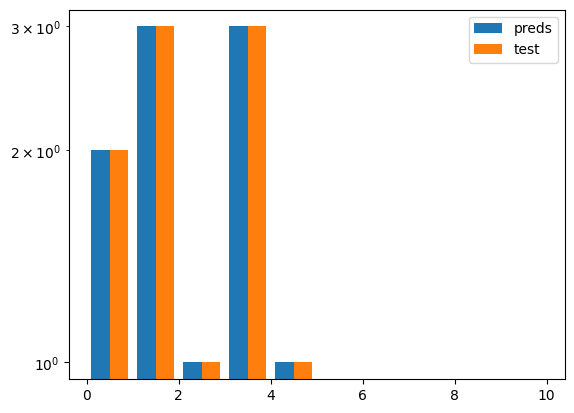

In [14]:
%%time

plt.hist((y_pred, y_values), bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], log=True)
plt.legend(labels=('preds', 'test'))